## EENG 439: Neural Networks and Learning Systems Final Project

### Corn Future Predictions using Convolutional Neural Networks

In [1]:
# Install Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
import pickle

In [2]:
## Load in the data
corn_files = ['USDAProj_Corn_2017to2018.csv',
'USDAProj_Corn_2016to2017.csv',
'USDAProj_Corn_2015to2016.csv',
'USDAProj_Corn_2009to2010.csv',
'USDAProj_Corn_2014to2015.csv',
'USDAProj_Corn_2013to2014.csv',
'USDAProj_Corn_2012to2013.csv',
'USDAProj_Corn_2011to2012.csv',
'USDAProj_Corn_2010to2011.csv',
'USDAProj_Corn_2008to2009.csv',
'USDAProj_Corn_2007to2008.csv']

soybeans_files = ['USDAProj_Soybean_2017to2018.csv',
'USDAProj_Soybean_2016to2017.csv',
'USDAProj_Soybean_2015to2016.csv',
'USDAProj_Soybean_2009to2010.csv',
'USDAProj_Soybean_2014to2015.csv',
'USDAProj_Soybean_2013to2014.csv',
'USDAProj_Soybean_2012to2013.csv',
'USDAProj_Soybean_2011to2012.csv',
'USDAProj_Soybean_2010to2011.csv',
'USDAProj_Soybean_2008to2009.csv',
'USDAProj_Soybean_2007to2008.csv']

corn_files.sort()
soybeans_files.sort()

monthly_corn_data = pd.read_csv('Data/USDAProj_Corn_2007to2008.csv')
for file in corn_files[1:]:
    file_path = str('Data/' + file)
    monthly_corn_data = monthly_corn_data.append(pd.read_csv(file_path))
monthly_corn_data.sort_values(by="Date")
    
corn_prices = pd.read_csv('Data/Corn_prices.csv')
corn_prices_new = pd.read_csv('Data/corn_prices_edited.csv')

monthly_soybean_data = pd.read_csv('Data/USDAProj_Soybean_2007to2008.csv')
for file in soybeans_files[1:]:
    file_path = str('Data/' + file)
    monthly_soybean_data = monthly_soybean_data.append(pd.read_csv(file_path))
    
monthly_soybean_data.sort_values(by="Date")
    
soybean_prices = pd.read_csv('Data/Soybean_prices.csv')

weather = pd.read_csv('Data/weather_data_iowa.csv')

In [3]:
weather

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TMAX,TMIN,WDMV,WSF2,WSF5
0,USW00014933,41.53380,-93.65300,291.7,2004-01-01,0.00,52.0,27.0,NaN,21.0,23.0
1,USW00014933,41.53380,-93.65300,291.7,2004-01-02,0.00,60.0,31.0,NaN,21.0,25.9
2,USW00014933,41.53380,-93.65300,291.7,2004-01-03,0.00,34.0,20.0,NaN,19.9,21.9
3,USW00014933,41.53380,-93.65300,291.7,2004-01-04,0.30,21.0,11.0,NaN,21.9,29.1
4,USW00014933,41.53380,-93.65300,291.7,2004-01-05,0.00,11.0,-5.0,NaN,23.9,29.1
...,...,...,...,...,...,...,...,...,...,...,...
23353,USW00094988,42.11056,-92.91611,296.9,2019-12-27,0.00,40.0,21.0,NaN,18.1,23.0
23354,USW00094988,42.11056,-92.91611,296.9,2019-12-28,0.84,49.0,31.0,NaN,21.9,27.1
23355,USW00094988,42.11056,-92.91611,296.9,2019-12-29,0.01,52.0,30.0,NaN,23.9,35.1
23356,USW00094988,42.11056,-92.91611,296.9,2019-12-30,0.00,30.0,22.0,NaN,28.0,40.0


In [4]:
print(monthly_corn_data.shape)
print(monthly_soybean_data.shape)

print(corn_prices.shape)
print(soybean_prices.shape)

(248, 113)
(248, 70)
(1035, 8)
(942, 8)


In [5]:
monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,90.5,82.9,150.3,937.0,12460.0,15.0,13412.0,5700.0,4790.0,...,21.35,0.24,1.95,10.42,55.37,3.5,45.3,60.3,0.3,8.69
1,2007/06/11,90.5,82.9,150.3,987.0,12460.0,15.0,13462.0,5700.0,4790.0,...,21.35,0.24,1.95,10.72,55.72,3.5,45.8,60.8,0.3,8.84
2,2007/07/12,92.9,85.4,150.3,1137.0,12840.0,15.0,13992.0,5700.0,4790.0,...,21.35,0.24,1.97,10.72,55.23,3.5,45.8,60.8,0.3,8.35
3,2007/08/10,92.9,85.4,152.8,1137.0,13054.0,15.0,14206.0,5750.0,4790.0,...,21.35,0.24,1.92,10.72,48.43,6.0,45.8,60.8,0.3,4.05
4,2007/09/12,92.9,85.4,155.8,1142.0,13308.0,15.0,14465.0,5850.0,4690.0,...,21.35,0.24,1.77,10.62,46.94,8.0,46.5,61.5,0.3,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2017/11/09,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6935.0,...,43.70,0.72,2.67,7.09,59.59,16.0,56.0,74.7,1.5,6.47
7,2017/12/12,90.4,83.1,175.4,2295.0,14578.0,50.0,16922.0,5575.0,6985.0,...,43.70,0.72,2.77,7.55,60.09,16.0,56.0,74.8,2.0,6.84
8,2018/01/12,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.70,0.82,2.75,7.54,60.09,16.0,56.0,74.8,2.0,6.83
9,2018/02/08,90.2,82.7,176.6,2293.0,14604.0,50.0,16947.0,5550.0,6995.0,...,43.80,0.82,2.73,7.54,60.09,16.2,56.2,75.0,2.0,6.83


In [6]:
len(monthly_corn_data[monthly_corn_data.isna().any(axis=1)]) == 0
len(monthly_soybean_data[monthly_soybean_data.isna().any(axis=1)]) == 0
len(corn_prices[corn_prices.isna().any(axis=1)]) == 0
len(soybean_prices[soybean_prices.isna().any(axis=1)]) == 0

True

In [7]:
normalized_monthly_corn_data=(monthly_corn_data.iloc[:,1:]-monthly_corn_data.iloc[:,1:].mean())/monthly_corn_data.iloc[:,1:].std()
#normalized_monthly_corn_data.drop_duplicates().reset_index(drop=True)
normalized_monthly_corn_data.insert(0, 'Date', monthly_corn_data['Date'])#.drop_duplicates().reset_index(drop=True))
normalized_monthly_corn_data = normalized_monthly_corn_data.sort_values(by='Date').reset_index(drop=True)

In [8]:
to_delete = []
#get rid of the duplicate reports
for i in range(1,len(normalized_monthly_corn_data)):
    if normalized_monthly_corn_data['Date'][i] == normalized_monthly_corn_data['Date'][i-1]:
        to_delete.append(i)

In [9]:
normalized_monthly_corn_data = normalized_monthly_corn_data.drop(to_delete).reset_index(drop=True)

In [10]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
1,2007/06/11,-0.166298,-0.194336,-0.558742,-1.126988,-0.625089,-0.650767,-0.909783,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.611096,-0.698195,-1.122585,-1.134327,-1.052182,-1.712385,2.173196
2,2007/07/12,0.501137,0.586030,-0.558742,-0.736071,-0.291844,-0.650767,-0.496527,1.170855,-1.762278,...,-1.708698,-1.128923,-1.237508,2.611096,-0.774917,-1.122585,-1.134327,-1.052182,-1.712385,1.823231
3,2007/08/10,0.501137,0.586030,-0.373193,-0.736071,-0.104174,-0.650767,-0.329665,1.290236,-1.762278,...,-1.708698,-1.128923,-1.298658,2.611096,-1.839631,-0.590660,-1.134327,-1.052182,-1.712385,-1.247886
4,2007/09/12,0.501137,0.586030,-0.150534,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,...,-1.708698,-1.128923,-1.482110,2.550054,-2.072929,-0.165120,-0.993941,-0.947355,-1.712385,-1.455008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017/11/09,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.071112,0.151080,0.144182,1.281716,0.690688,0.849689,0.263372,0.923322
126,2017/12/12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.193413,0.169393,0.198984,1.377463,0.710743,0.879640,0.460948,1.251861
127,2018/01/12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.614541,1.110892,...,1.506934,1.720321,0.242333,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
128,2018/02/08,-0.249728,-0.256766,1.393234,2.276602,1.255115,0.402890,1.807572,0.812713,1.255988,...,1.672611,0.475506,-0.308021,0.669942,-0.013959,1.579594,0.951405,1.074319,0.263372,0.737627


In [11]:
fields = list(normalized_monthly_corn_data.keys())

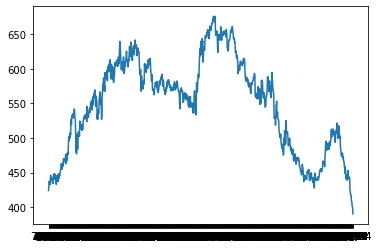

In [12]:
plt.plot(corn_prices['dates'], corn_prices['Close'])

In [13]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007/05/11,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
1,2007/06/11,-0.166298,-0.194336,-0.558742,-1.126988,-0.625089,-0.650767,-0.909783,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.611096,-0.698195,-1.122585,-1.134327,-1.052182,-1.712385,2.173196
2,2007/07/12,0.501137,0.586030,-0.558742,-0.736071,-0.291844,-0.650767,-0.496527,1.170855,-1.762278,...,-1.708698,-1.128923,-1.237508,2.611096,-0.774917,-1.122585,-1.134327,-1.052182,-1.712385,1.823231
3,2007/08/10,0.501137,0.586030,-0.373193,-0.736071,-0.104174,-0.650767,-0.329665,1.290236,-1.762278,...,-1.708698,-1.128923,-1.298658,2.611096,-1.839631,-0.590660,-1.134327,-1.052182,-1.712385,-1.247886
4,2007/09/12,0.501137,0.586030,-0.150534,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,...,-1.708698,-1.128923,-1.482110,2.550054,-2.072929,-0.165120,-0.993941,-0.947355,-1.712385,-1.455008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017/11/09,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.071112,0.151080,0.144182,1.281716,0.690688,0.849689,0.263372,0.923322
126,2017/12/12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.193413,0.169393,0.198984,1.377463,0.710743,0.879640,0.460948,1.251861
127,2018/01/12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.614541,1.110892,...,1.506934,1.720321,0.242333,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
128,2018/02/08,-0.249728,-0.256766,1.393234,2.276602,1.255115,0.402890,1.807572,0.812713,1.255988,...,1.672611,0.475506,-0.308021,0.669942,-0.013959,1.579594,0.951405,1.074319,0.263372,0.737627


In [14]:
corn_prices['dates'] = pd.to_datetime(corn_prices['dates'])
normalized_monthly_corn_data['Date'] = pd.to_datetime(normalized_monthly_corn_data['Date'])

In [15]:
normalized_monthly_corn_data

,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
1,2007-06-11,-0.166298,-0.194336,-0.558742,-1.126988,-0.625089,-0.650767,-0.909783,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.611096,-0.698195,-1.122585,-1.134327,-1.052182,-1.712385,2.173196
2,2007-07-12,0.501137,0.586030,-0.558742,-0.736071,-0.291844,-0.650767,-0.496527,1.170855,-1.762278,...,-1.708698,-1.128923,-1.237508,2.611096,-0.774917,-1.122585,-1.134327,-1.052182,-1.712385,1.823231
3,2007-08-10,0.501137,0.586030,-0.373193,-0.736071,-0.104174,-0.650767,-0.329665,1.290236,-1.762278,...,-1.708698,-1.128923,-1.298658,2.611096,-1.839631,-0.590660,-1.134327,-1.052182,-1.712385,-1.247886
4,2007-09-12,0.501137,0.586030,-0.150534,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,...,-1.708698,-1.128923,-1.482110,2.550054,-2.072929,-0.165120,-0.993941,-0.947355,-1.712385,-1.455008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2017-11-09,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.071112,0.151080,0.144182,1.281716,0.690688,0.849689,0.263372,0.923322
126,2017-12-12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.604991,1.113630,...,1.506934,1.720321,0.193413,0.169393,0.198984,1.377463,0.710743,0.879640,0.460948,1.251861
127,2018-01-12,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.614541,1.110892,...,1.506934,1.720321,0.242333,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
128,2018-02-08,-0.249728,-0.256766,1.393234,2.276602,1.255115,0.402890,1.807572,0.812713,1.255988,...,1.672611,0.475506,-0.308021,0.669942,-0.013959,1.579594,0.951405,1.074319,0.263372,0.737627


In [16]:
price_years = []
for i in range(len(corn_prices['dates'])):
    price_years.append(corn_prices['dates'][i].year)
    
price_years = np.unique(price_years)

In [17]:
data_years = []
for i in range(len(normalized_monthly_corn_data['Date'])):
    data_years.append(normalized_monthly_corn_data['Date'][i].year)
    
data_years = np.unique(data_years)

In [18]:
data_years

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [19]:
to_add = []
for i in range(len(normalized_monthly_corn_data)-1):
    if (normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days > 0: 
        to_add.append((normalized_monthly_corn_data['Date'][i+1] - normalized_monthly_corn_data['Date'][i]).days)
    else:
        to_add.append(365 - (normalized_monthly_corn_data['Date'][i] - normalized_monthly_corn_data['Date'][i+1]).days)
to_add.append(30)

In [20]:
np.mean(to_add)

30.646153846153847

In [21]:
list(normalized_monthly_corn_data["Date"])

[Timestamp('2007-05-11 00:00:00'),
 Timestamp('2007-06-11 00:00:00'),
 Timestamp('2007-07-12 00:00:00'),
 Timestamp('2007-08-10 00:00:00'),
 Timestamp('2007-09-12 00:00:00'),
 Timestamp('2007-10-12 00:00:00'),
 Timestamp('2007-11-09 00:00:00'),
 Timestamp('2007-12-11 00:00:00'),
 Timestamp('2008-01-11 00:00:00'),
 Timestamp('2008-02-08 00:00:00'),
 Timestamp('2008-03-11 00:00:00'),
 Timestamp('2008-04-09 00:00:00'),
 Timestamp('2008-05-09 00:00:00'),
 Timestamp('2008-06-10 00:00:00'),
 Timestamp('2008-07-11 00:00:00'),
 Timestamp('2008-08-12 00:00:00'),
 Timestamp('2008-09-12 00:00:00'),
 Timestamp('2008-10-10 00:00:00'),
 Timestamp('2008-11-10 00:00:00'),
 Timestamp('2008-12-12 00:00:00'),
 Timestamp('2009-01-12 00:00:00'),
 Timestamp('2009-02-10 00:00:00'),
 Timestamp('2009-03-11 00:00:00'),
 Timestamp('2009-04-09 00:00:00'),
 Timestamp('2009-05-12 00:00:00'),
 Timestamp('2009-06-10 00:00:00'),
 Timestamp('2009-07-10 00:00:00'),
 Timestamp('2009-08-12 00:00:00'),
 Timestamp('2009-09-

In [22]:
numberr = 0
for add in to_add:
    numberr += add
numberr

3984

In [23]:
normalized_monthly_corn_data = normalized_monthly_corn_data.loc[normalized_monthly_corn_data.index.repeat(to_add)].reset_index(drop=True)

In [24]:
for i in range(1,len(normalized_monthly_corn_data)):
    normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)
normalized_monthly_corn_data

<ipython-input-24-44406f9f06c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_monthly_corn_data['Date'][i] = normalized_monthly_corn_data['Date'][i-1]+timedelta(days=1)


,Date,Area Planted,Area Harvested,Yield,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,2007-05-11,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
1,2007-05-12,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
2,2007-05-13,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
3,2007-05-14,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
4,2007-05-15,-0.166298,-0.194336,-0.558742,-1.257294,-0.625089,-0.650767,-0.948770,1.170855,-1.762278,...,-1.708698,-1.128923,-1.261968,2.427969,-0.752996,-1.122585,-1.234602,-1.127059,-1.712385,2.066064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,2018-04-02,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.628867,1.101311,...,1.506934,1.720321,0.230103,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
3980,2018-04-03,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.628867,1.101311,...,1.506934,1.720321,0.230103,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
3981,2018-04-04,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.628867,1.101311,...,1.506934,1.720321,0.230103,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719
3982,2018-04-05,0.807045,0.991820,1.244795,0.827600,1.732182,0.613622,1.803674,0.628867,1.101311,...,1.506934,1.720321,0.230103,0.169393,0.198984,1.375335,0.710743,0.879640,0.460948,1.244719


In [25]:
#corn_year_dict = {}

#for year in price_years:
#    corn_year_dict[year] = pd.DataFrame(columns = corn_prices.columns)
##    for i in range(len(corn_prices)):
 #       if corn_prices['dates'][i].year == year:
 #           corn_year_dict[year] = corn_year_dict[year].append(corn_prices.iloc[i,:])
 #           
 #   plt.plot(corn_year_dict[year]['dates'], corn_year_dict[year]['Close'])
 #   plt.show()

In [26]:
#corn_year_dict_new

In [27]:
#np.sort(corn_year_dict_new[key]['Close'])[-20]

In [28]:
#corn_year_dict_new[key]['Close']

In [29]:
corn_prices_new['Date'] = pd.to_datetime(corn_prices_new['Date'])

In [30]:
corn_prices_new

,Open,Close,High,Low,Volume,Date
0,3.7550,3.7500,3.7700,3.7275,NaN,2018-12-31
1,3.7450,3.7550,3.7750,3.7450,NaN,2018-12-28
2,3.7325,3.7450,3.7650,3.7325,NaN,2018-12-27
3,3.7825,3.7325,3.7925,3.7250,NaN,2018-12-26
4,3.7825,3.7775,3.7900,3.7525,NaN,2018-12-24
...,...,...,...,...,...,...
2952,3.5975,3.6025,3.6100,3.5875,NaN,2007-04-04
2953,3.4700,3.4850,3.5000,3.4700,NaN,2007-04-03
2954,3.5600,3.5700,3.5725,3.5500,NaN,2007-04-02
2955,0.0000,3.7450,3.9775,3.7400,NaN,2007-03-30


In [31]:
corn_prices_new1 = (corn_prices_new.iloc[:,:-1]-corn_prices_new.iloc[:,:-1].mean())/corn_prices_new.iloc[:,:-1].std()
corn_prices_new1['Date'] = corn_prices_new['Date']
corn_prices_new = corn_prices_new1
corn_prices_new

,Open,Close,High,Low,Volume,Date
0,-0.520323,-0.582336,-0.553287,-0.521468,NaN,2018-12-31
1,-0.526993,-0.578839,-0.549963,-0.509474,NaN,2018-12-28
2,-0.535330,-0.585832,-0.556610,-0.518041,NaN,2018-12-27
3,-0.501981,-0.594573,-0.538329,-0.523181,NaN,2018-12-26
4,-0.501981,-0.563106,-0.539991,-0.504334,NaN,2018-12-24
...,...,...,...,...,...,...
2952,-0.625374,-0.685480,-0.659652,-0.617417,NaN,2007-04-04
2953,-0.710416,-0.767645,-0.732778,-0.697947,NaN,2007-04-03
2954,-0.650387,-0.708206,-0.684581,-0.643118,NaN,2007-04-02
2955,-3.024882,-0.585832,-0.415344,-0.512901,NaN,2007-03-30


In [32]:
weather['Date'] = pd.to_datetime(weather['DATE'])
weather_subset = weather[weather['STATION'] == 'USW00014933']
weather_subset = weather_subset[list(weather_subset.columns[-7:])]

weather_subset1 = (weather_subset.iloc[:,:-1]-weather_subset.iloc[:,:-1].mean())/weather_subset.iloc[:,:-1].std()
weather_subset1['Date'] = weather_subset['Date']
weather_subset = weather_subset1
weather_subset

,PRCP,TMAX,TMIN,WDMV,WSF2,WSF5,Date
0,-0.334083,-0.422309,-0.742414,NaN,0.077627,-0.372992,2004-01-01
1,-0.334083,-0.064113,-0.550206,NaN,0.077627,-0.046121,2004-01-02
2,-0.334083,-1.228252,-1.078778,NaN,-0.080090,-0.496977,2004-01-03
3,0.618051,-1.810321,-1.511246,NaN,0.206669,0.314564,2004-01-04
4,-0.334083,-2.258067,-2.280079,NaN,0.493428,0.314564,2004-01-05
...,...,...,...,...,...,...,...
5839,-0.334083,-0.825281,-0.886570,NaN,-0.495891,-0.372992,2019-12-27
5840,2.331893,-0.467084,-0.357998,NaN,-0.624933,-0.496977,2019-12-28
5841,-0.334083,-0.422309,-0.694362,NaN,1.239002,1.644590,2019-12-29
5842,-0.334083,-1.496899,-0.886570,NaN,1.239002,1.317720,2019-12-30


In [33]:
full_data = corn_prices_new.merge(weather_subset, how = 'left', on = 'Date' )
full_data = full_data.merge(normalized_monthly_corn_data, how = 'left', on = 'Date' )
full_data 

,Open,Close,High,Low,Volume,Date,PRCP,TMAX,TMIN,WDMV,...,Southeast Asia DomesticTotal,Southeast Asia Exports,Southeast Asia EndingStocks,European Union BeginningStocks,European Union Production,European Union Imports,European Union DomesticFeed,European Union DomesticTotal,European Union Exports,European Union EndingStocks
0,-0.520323,-0.582336,-0.553287,-0.521468,NaN,2018-12-31,0.015033,-1.183477,-1.078778,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.526993,-0.578839,-0.549963,-0.509474,NaN,2018-12-28,-0.302346,-1.496899,-1.415142,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.535330,-0.585832,-0.556610,-0.518041,NaN,2018-12-27,2.522320,-0.332760,-0.694362,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.501981,-0.594573,-0.538329,-0.523181,NaN,2018-12-26,1.411496,-0.914830,-0.598258,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.501981,-0.563106,-0.539991,-0.504334,NaN,2018-12-24,-0.334083,-1.138703,-1.126830,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,-0.625374,-0.685480,-0.659652,-0.617417,NaN,2007-04-04,-0.334083,-1.093928,-1.078778,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2953,-0.710416,-0.767645,-0.732778,-0.697947,NaN,2007-04-03,0.681527,-0.422309,-0.838518,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2954,-0.650387,-0.708206,-0.684581,-0.643118,NaN,2007-04-02,-0.334083,0.025437,-0.117737,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2955,-3.024882,-0.585832,-0.415344,-0.512901,NaN,2007-03-30,0.364149,0.473183,0.603043,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
subset = full_data[['Date', 'Close', 'High', 'Low','PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5','Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']]

def generate_time_lags(df,col, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n, col}"] = df_n[col].shift(n)
    #df_n = df_n.iloc[n_lags:]
    
    
    return df_n

df_generated = subset

for column in list(df_generated.keys())[1:]:
    df_generated = generate_time_lags(df_generated, column, 20)
df_generated


,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,2018-12-31,-0.582336,-0.553287,-0.521468,0.015033,-1.183477,-1.078778,0.364386,0.416007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-28,-0.578839,-0.549963,-0.509474,-0.302346,-1.496899,-1.415142,0.665484,0.990849,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-12-27,-0.585832,-0.556610,-0.518041,2.522320,-0.332760,-0.694362,1.525761,1.543148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-12-26,-0.594573,-0.538329,-0.523181,1.411496,-0.914830,-0.598258,-0.338174,0.416007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-12-24,-0.563106,-0.539991,-0.504334,-0.334083,-1.138703,-1.126830,-1.069410,-1.049276,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,2007-04-04,-0.685480,-0.659652,-0.617417,-0.334083,-1.093928,-1.078778,1.654803,1.543148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2953,2007-04-03,-0.767645,-0.732778,-0.697947,0.681527,-0.422309,-0.838518,2.357363,2.005275,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2954,2007-04-02,-0.708206,-0.684581,-0.643118,-0.334083,0.025437,-0.117737,-0.366850,-0.496977,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2955,2007-03-30,-0.585832,-0.415344,-0.512901,0.364149,0.473183,0.603043,-0.782651,-0.722406,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
subset = subset[subset['Close']!= -3.204636436946188].sort_values(by='Date', ascending = True).reset_index(drop=True)

In [36]:
subset

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,2007-03-29,-0.449473,-0.438612,-0.386110,-0.302346,-0.153662,0.458887,-0.495891,-0.598420,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-30,-0.585832,-0.415344,-0.512901,0.364149,0.473183,0.603043,-0.782651,-0.722406,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-02,-0.708206,-0.684581,-0.643118,-0.334083,0.025437,-0.117737,-0.366850,-0.496977,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-03,-0.767645,-0.732778,-0.697947,0.681527,-0.422309,-0.838518,2.357363,2.005275,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-04,-0.685480,-0.659652,-0.617417,-0.334083,-1.093928,-1.078778,1.654803,1.543148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,2018-12-24,-0.563106,-0.539991,-0.504334,-0.334083,-1.138703,-1.126830,-1.069410,-1.049276,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2930,2018-12-26,-0.594573,-0.538329,-0.523181,1.411496,-0.914830,-0.598258,-0.338174,0.416007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2931,2018-12-27,-0.585832,-0.556610,-0.518041,2.522320,-0.332760,-0.694362,1.525761,1.543148,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,2018-12-28,-0.578839,-0.549963,-0.509474,-0.302346,-1.496899,-1.415142,0.665484,0.990849,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
subset_matrices = []
for i in range(len(subset)):
    subset_matrices.append(subset.iloc[i-22:i,0:23])


In [59]:
subset_matrices[22].isnull().values.any()

True

In [39]:
[x for x in range(20)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [67]:
matrices_dict = {}
i = 0
for year in data_years:
    
    days_since_harvest = 0
    
    matrices_dict[year] = []
    
    while subset_matrices[i+22]['Date'][i].month != 10 or subset_matrices[i+22]['Date'][i].year != year:

    #for i in range(len(corn_prices_new)):
        #if corn_prices_new['Date'][i].year == year:
            subset_matrices[i+1]['Days Since Harvest'] = [x for x in range(days_since_harvest-21, days_since_harvest+1)]
            matrices_dict[year].append(subset_matrices[i+1])
            i = i + 1
            days_since_harvest = days_since_harvest +1

In [68]:
for key in matrices_dict.keys():
    length = [x for x in range(-21, len(matrices_dict[key]))]
    
    for i in range(len(matrices_dict[key])):
        matrices_dict[key][i]['Days Since Harvest'] = (matrices_dict[key][i]['Days Since Harvest'] - np.mean(length))/np.std(length)

In [71]:
matrices_dict[2008][222]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
329,2008-08-20,0.817973,0.781265,0.789276,-0.334083,0.920928,1.083564,-0.782651,-0.722406,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.401142
330,2008-08-21,0.975311,0.964080,0.859525,-0.111919,0.517957,1.131616,-0.624933,-0.496977,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.415224
331,2008-08-25,0.852937,0.987347,0.888653,-0.334083,0.741830,0.747199,-0.911692,NaN,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.429306
332,2008-08-26,0.817973,0.817828,0.818404,-0.334083,0.786605,0.747199,-0.624933,-0.722406,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.443388
333,2008-08-27,0.833707,0.831123,0.811550,0.205459,0.741830,0.891355,0.493428,0.314564,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.457469
334,2008-08-28,0.781261,0.786251,0.787563,-0.334083,1.055252,1.083564,-0.624933,-0.271549,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.471551
335,2008-09-01,0.769023,0.718110,0.818404,-0.334083,1.279125,1.131616,-0.080090,-0.046121,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.485633
336,2008-09-02,0.662383,0.664928,0.600803,-0.302346,1.189576,0.987460,0.493428,0.190579,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.499715
337,2008-09-03,0.616930,0.656618,0.583669,-0.334083,0.159760,0.603043,-0.366850,-0.271549,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.513797
338,2008-09-04,0.636160,0.639998,0.624791,1.348021,0.204535,0.506939,-0.624933,-0.598420,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,1.527879


In [ ]:
len(subset_matrices)

In [ ]:
def make_year_dict(corn_price):
    price_years_new = []
    for i in range(len(corn_price['Date'])):
        price_years_new.append(corn_price['Date'][i].year)

    price_years_new = np.unique(price_years_new)
    
    to_delete = []
    for i in tqdm(range(len(corn_price))):
        if corn_price['Close'][i] == -3.204636436946188:
            to_delete.append(i)
            
    corn_price = corn_price.drop(to_delete)
    corn_price = corn_price.reset_index(drop=True)
    
    corn_price = corn_price.sort_values(by = 'Date').reset_index(drop=True)
    
    corn_year_dict_new = {}

    i = 0
    for year in price_years_new:
        corn_year_dict_new[year] = pd.DataFrame(columns = corn_price.columns)

        while corn_price['Date'][i].month != 10 or corn_price['Date'][i].year != year:

        #for i in range(len(corn_prices_new)):
            #if corn_prices_new['Date'][i].year == year:
                corn_year_dict_new[year] = corn_year_dict_new[year].append(corn_price.iloc[i,:])
                i = i + 1

        corn_year_dict_new[year] = corn_year_dict_new[year].reset_index(drop=True)
        #plt.plot(corn_year_dict_new[year]['Date'], corn_year_dict_new[year]['Close'])
        #plt.show()
        
    return corn_year_dict_new

In [ ]:
regular_dict = make_year_dict(full_data)

In [ ]:
lagged_dict = make_year_dict(df_generated)

In [ ]:
subset_dict = make_year_dict(subset)

In [ ]:
subset_dict[2008]



In [ ]:
for i in range(len(corn_prices_new)):
    if corn_prices_new['Close'][i] ==0:
        corn_prices_new = corn_prices_new.drop(i)
corn_prices_new = corn_prices_new.reset_index(drop=True)

In [ ]:
corn_prices_new = corn_prices_new.sort_values(by = 'Date').reset_index(drop=True)

In [ ]:
corn_year_dict_new = {}

i = 0
for year in price_years_new:
    corn_year_dict_new[year] = pd.DataFrame(columns = corn_prices_new.columns)
    
    while corn_prices_new['Date'][i].month != 10 or corn_prices_new['Date'][i].year != year:
        
    #for i in range(len(corn_prices_new)):
        #if corn_prices_new['Date'][i].year == year:
            corn_year_dict_new[year] = corn_year_dict_new[year].append(corn_prices_new.iloc[i,:])
            i = i + 1
    
    corn_year_dict_new[year] = corn_year_dict_new[year].reset_index(drop=True)
    plt.plot(corn_year_dict_new[year]['Date'], corn_year_dict_new[year]['Close'])
    plt.show()

In [ ]:
def label(corn_year_dict_new):
    for key in corn_year_dict_new.keys():
        labels = []
        sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-20]
        buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[20]
        for i in range(len(corn_year_dict_new[key])):
            if corn_year_dict_new[key]['Close'][i] >= sell_threshold:
                labels.append(2)
            elif corn_year_dict_new[key]['Close'][i] <= buy_threshold:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [ ]:
def label_updated(corn_year_dict_new,n):
    for key in corn_year_dict_new.keys():
        labels = []
        
        for i in range(len(corn_year_dict_new[key])):
            
            if i-n<0:
                window = corn_year_dict_new[key]['Close'][0:i+n]
            elif i+10>len(corn_year_dict_new[key]['Close']):
                window = corn_year_dict_new[key]['Close'][i-n:len(corn_year_dict_new[key]['Close'])]
            else:
                window = corn_year_dict_new[key]['Close'][i-n:i+n]
                
            if max(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(2)
            elif min(window) == corn_year_dict_new[key]['Close'][i]:
                labels.append(0)
            else:
                labels.append(1)

        corn_year_dict_new[key]['Days Since Harvest'] = (np.array(corn_year_dict_new[key].index) - np.array(corn_year_dict_new[key].index).mean())/np.array(corn_year_dict_new[key].index).std()
        
        corn_year_dict_new[key]['Labels'] = labels

    return corn_year_dict_new

In [ ]:
labeled_dict = label(regular_dict)
min(labeled_dict[2008]['Labels'])

In [ ]:
labeled_dict_lagged = label_updated(lagged_dict, 10)

labeled_dict_lagged[2008]

data_lagged = {}
label_lagged = {}
for key in labeled_dict_lagged.keys():
    data_lagged[key] = labeled_dict_lagged[key].iloc[:,:-1]
    label_lagged[key] = labeled_dict_lagged[key].iloc[:,-1]

In [ ]:
label_lagged[2008]

In [ ]:
del data_lagged[2018]
del data_lagged[2007]
del label_lagged[2018]
del label_lagged[2007]

In [ ]:
sells = {}
buys = {}
for key in label_lagged.keys():
    sell = []
    buy = []
    for i in range(len(label_lagged[key])):
        if label_lagged[key][i] == 2:
            sell.append(i)
        if label_lagged[key][i] == 0:
            buy.append(i)
    sells[key] = sell
    buys[key] = buy

In [ ]:
print(sells)
print(buys)

In [ ]:
for key in data_lagged.keys():
    plt.plot(data_lagged[key]['Close'])
    for sell in sells[key]:
        plt.plot(sell, data_lagged[key]['Close'][sell], marker = '^', color = 'green')
    for buy in buys[key]:
        plt.plot(buy, data_lagged[key]['Close'][buy], marker = 'v', color = 'red')
    plt.show()

In [ ]:
data_lagged.keys()

In [ ]:
subset_dict_label = label(subset_dict)
subset_dict_label[2008]

In [ ]:
subset_dict_label[2007]

In [ ]:
all_labels_dict = {}
all_data_dict = {}

for key in tqdm(subset_dict_label.keys()):
    labels_list = []
    data_list = []
    for i in range(len(subset_dict_label[key])):
        if i<22:
            data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
        data_list.append(subset_dict_label[key].iloc[i-22:i,1:23])
        labels_list.append(subset_dict_label[key]['Labels'][i])
    
    all_data_dict[key] = data_list
    all_labels_dict[key] = labels_list
    

In [ ]:
all_data_dict[2008]

In [ ]:
del all_data_dict[2018]
del all_labels_dict[2018]
del all_data_dict[2007]
del all_labels_dict[2007]

In [ ]:
subset_matrices[2008]

In [62]:
for key in matrices_dict.keys():
    for i in range(len(matrices_dict[key])):
        if matrices_dict[key][i].isnull().values.any() == True:
            print(matrices_dict[key][i])


          Date     Close      High       Low      PRCP      TMAX      TMIN  \
310 2008-07-17  1.209570  1.351316  1.236471  6.203907  1.234351  1.275772   
311 2008-07-21  0.915872  0.992333  0.926348  1.189332  0.965703  1.131616   
312 2008-07-22  0.805735  0.889292  0.838965 -0.334083  1.010478  1.131616   
313 2008-07-23  0.791750  0.862701  0.650492 -0.302346  0.831379  1.035512   
314 2008-07-24  0.802239  0.822814  0.773856  3.950522  0.562732  1.083564   
315 2008-07-28  0.865174  0.867686  0.862952  0.459362  1.055252  1.227720   
316 2008-07-29  0.949088  0.907573  0.835538 -0.334083  1.010478  1.371876   
317 2008-07-30  1.001534  0.962418  0.945195 -0.334083  1.100027  1.227720   
318 2008-07-31  0.903635  0.950784  0.933201 -0.334083  1.144801  1.323824   
319 2008-08-04  0.540009  0.739716  0.590523  0.618051  1.458223  1.323824   
320 2008-08-05  0.468333  0.580168  0.463732  0.364149  1.010478  1.179668   
321 2008-08-06  0.347707  0.462169  0.369496 -0.334083  0.920928

          Date     Close      High       Low      PRCP      TMAX      TMIN  \
336 2008-09-02  0.662383  0.664928  0.600803 -0.302346  1.189576  0.987460   
337 2008-09-03  0.616930  0.656618  0.583669 -0.334083  0.159760  0.603043   
338 2008-09-04  0.636160  0.639998  0.624791  1.348021  0.204535  0.506939   
339 2008-09-08  0.522527  0.543605  0.542548  0.871954 -0.064113  0.218627   
340 2008-09-09  0.498052  0.490422  0.460305 -0.334083  0.294084  0.074471   
341 2008-09-10  0.449102  0.462169  0.492860 -0.302346  0.562732  0.554991   
342 2008-09-11  0.447354  0.437240  0.480866  0.015033  0.831379  0.987460   
343 2008-09-15  0.725318  0.940813  0.664199 -0.334083  0.294084  0.218627   
344 2008-09-16  0.517282  0.696505  0.569962 -0.334083  0.786605  0.314731   
345 2008-09-17  0.669376  0.743040  0.528841 -0.334083  0.965703  0.651095   
346 2008-09-18  0.482318  0.663266  0.515134 -0.334083  0.831379  0.843303   
347 2008-09-22  0.700843  0.802870  0.592236 -0.334083  0.741830

          Date     Close      High       Low      PRCP      TMAX      TMIN  \
521 2009-06-25 -0.529890 -0.473513 -0.464926 -0.334083  1.458223  1.516032   
522 2009-06-26 -0.517652 -0.488470 -0.473493 -0.334083  1.100027  1.516032   
523 2009-06-29 -0.568350 -0.503428 -0.500907 -0.334083  1.100027  0.891355   
524 2009-06-30 -0.772890 -0.521709 -0.761342 -0.334083  0.786605  0.939407   
525 2009-07-01 -0.744918 -0.702863 -0.725361 -0.334083  0.920928  0.939407   
526 2009-07-02 -0.786875 -0.716158 -0.732215 -0.334083  1.010478  0.891355   
527 2009-07-03 -0.786875 -3.059517 -3.076133  0.649789  0.965703  1.083564   
528 2009-07-06 -0.804357 -0.754383 -0.752775 -0.334083  1.100027  1.083564   
529 2009-07-07 -0.858551 -0.674609 -0.780190 -0.175394  1.144801  1.131616   
530 2009-07-08 -0.832328 -0.762693 -0.778476  1.221070  0.831379  1.035512   
531 2009-07-09 -0.802609 -0.762693 -0.754489 -0.016705  0.920928  0.939407   
532 2009-07-10 -0.788623 -0.747736 -0.766482 -0.302346  1.100027

[22 rows x 23 columns]
          Date     Close      High       Low      PRCP      TMAX      TMIN  \
804 2010-08-09 -0.386537 -0.327260 -0.327854  4.172686  1.234351  1.419928   
805 2010-08-10 -0.452969 -0.382105 -0.384396  5.696102  1.413449  1.419928   
806 2010-08-11 -0.438983 -0.397063 -0.399817  2.077991  1.458223  1.371876   
807 2010-08-12 -0.363811 -0.307317 -0.370689 -0.334083  1.458223  1.660188   
808 2010-08-13 -0.325350 -0.308979 -0.293587 -0.270608  1.323900  1.564084   
809 2010-08-16 -0.356818 -0.284050 -0.295300 -0.334083  1.100027  0.939407   
810 2010-08-17 -0.304372 -0.292359 -0.291873  1.538448  0.607506  1.035512   
811 2010-08-18 -0.278149 -0.269092 -0.273026 -0.334083  0.965703  0.939407   
812 2010-08-19 -0.307868 -0.249149 -0.257605 -0.334083  1.189576  1.227720   
813 2010-08-20 -0.258919 -0.254134 -0.273026  0.649789  0.831379  1.371876   
814 2010-08-23 -0.286890 -0.252472 -0.231905 -0.334083  1.189576  1.371876   
815 2010-08-24 -0.370804 -0.294021 -0.336

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1029 2011-06-20  1.693821  1.645482  1.690520  7.981224  0.965703  1.035512   
1030 2011-06-21  1.742771  1.721932  1.741921 -0.143657  0.786605  1.035512   
1031 2011-06-22  1.532987  1.687031  1.570582 -0.111919  0.249310  0.939407   
1032 2011-06-23  1.553965  1.480948  1.303293 -0.334083  0.383633  0.891355   
1033 2011-06-24  1.480541  1.579004  1.508900 -0.334083  0.741830  0.554991   
1034 2011-06-27  1.415857  1.391203  1.378683 -0.334083  0.876154  0.987460   
1035 2011-06-28  1.571447  1.487596  1.454072 -0.334083  0.876154  0.699147   
1036 2011-06-29  1.676339  1.690355  1.633978 -0.334083  1.144801  0.987460   
1037 2011-06-30  1.193836  1.650468  1.138808 -0.334083  1.547773  1.467980   
1038 2011-07-01  1.276001  1.279852  1.178216 -0.334083  1.502998  1.660188   
1039 2011-07-05  1.270757  1.489258  1.371829 -0.302346  1.010478  1.227720   
1040 2011-07-06  1.331944  1.

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1184 2012-01-31  1.263764  1.208388  1.248465 -0.334083 -0.019338 -0.213841   
1185 2012-02-01  1.284742  1.261570  1.296440 -0.334083 -0.064113 -0.646310   
1186 2012-02-02  1.291735  1.241627  1.270739 -0.334083 -0.287985 -0.790466   
1187 2012-02-03  1.302224  1.238303  1.296440 -0.238870 -0.959604 -0.406050   
1188 2012-02-06  1.300476  1.251598  1.305007 -0.334083 -1.228252 -0.982674   
1189 2012-02-07  1.286490  1.228331  1.305007 -0.302346 -1.183477 -0.886570   
1190 2012-02-08  1.288239  1.253260  1.255319 -0.334083 -1.452125 -1.367090   
1191 2012-02-09  1.249778  1.274866  1.260459 -0.334083 -1.228252 -1.559298   
1192 2012-02-10  1.213066  1.186782  1.229618 -0.334083 -1.362576 -1.511246   
1193 2012-02-13  1.267260  1.218359  1.260459  0.110246 -1.317801 -0.742414   
1194 2012-02-14  1.225303  1.198416  1.251892 -0.334083 -0.959604 -0.838518   
1195 2012-02-15  1.179850  1.

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1299 2012-07-13  1.973533  2.218857  2.091453  0.395886  1.279125  1.419928   
1300 2012-07-16  2.227022  2.127450  2.058899 -0.334083  1.637322  1.467980   
1301 2012-07-17  2.246253  2.235477  2.180549 -0.334083  1.726871  1.660188   
1302 2012-07-18  2.354641  2.238801  2.156562 -0.334083  1.861195  1.612136   
1303 2012-07-19  2.443799  2.370095  2.339895 -0.334083  1.502998  1.419928   
1304 2012-07-20  2.560929  2.449869  2.403290 -0.334083  1.279125  1.275772   
1305 2012-07-23  2.487504  2.418292  2.374163 -0.334083  1.950744  1.660188   
1306 2012-07-24  2.319677  2.361786  2.228524 -0.334083  1.816420  1.804344   
1307 2012-07-25  2.351145  2.296969  2.281640  1.252807  1.995519  1.467980   
1308 2012-07-26  2.258490  2.255420  2.243945 -0.207132  1.502998  1.419928   
1309 2012-07-27  2.379116  2.265392  2.245658 -0.334083  1.010478  1.179668   
1310 2012-07-30  2.529461  2.411644  2.405004 -0.334

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1368 2012-10-19  2.120382  2.052662  2.120581 -0.111919 -0.556633  0.026419   
1369 2012-10-22  2.118634  2.039366  2.124008  0.586313  0.517957  1.035512   
1370 2012-10-23  2.081922  2.009451  2.060612 -0.270608  0.607506  0.891355   
1371 2012-10-24  2.071432  2.016099  2.074319 -0.334083  0.697055  0.699147   
1372 2012-10-25  1.984022  1.976212  2.000643  0.015033 -0.198436 -0.165789   
1373 2012-10-26  1.954303  1.891452  1.974943 -0.334083 -0.735731 -0.454102   
1374 2012-10-29  1.949058  1.899762  1.944102 -0.334083 -0.422309 -0.309946   
1375 2012-10-30  1.982274  1.884804  1.968089 -0.334083 -0.332760 -0.550206   
1376 2012-10-31  2.080173  1.977874  2.007497 -0.334083 -0.198436 -0.550206   
1377 2012-11-01  2.046958  2.014437  2.064039 -0.334083 -0.064113 -0.117737   
1378 2012-11-02  1.966540  1.936325  1.968089 -0.334083 -0.556633 -0.309946   
1379 2012-11-05  1.938569  1.

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
1564 2013-07-31  0.284772  0.261072  0.302673 -0.334083  1.100027  1.083564   
1565 2013-08-01  0.204354  0.262734  0.258125 -0.334083  1.234351  0.987460   
1566 2013-08-02  0.123937  0.192932  0.181023 -0.334083  1.055252  1.227720   
1567 2013-08-05  0.076736  0.098200  0.114200 -0.334083  1.055252  1.083564   
1568 2013-08-06  0.097714  0.101524  0.114200  0.459362  1.368674  1.323824   
1569 2013-08-07  0.069743  0.106510  0.126194 -0.334083  1.010478  1.275772   
1570 2013-08-08  0.106455  0.101524  0.131334 -0.334083  0.965703  1.035512   
1571 2013-08-09  0.052261  0.109834  0.103920 -0.334083  1.010478  1.179668   
1572 2013-08-12  0.095966  0.131440  0.055945  1.284545  1.055252  1.131616   
1573 2013-08-13 -0.021163  0.108172  0.033671 -0.334083  0.876154  0.843303   
1574 2013-08-14  0.045268  0.036708  0.042238 -0.334083  0.697055  0.699147   
1575 2013-08-15  0.162398  0.164679  0.105633 -0.334

           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2443 2017-01-20 -0.619048 -0.599821 -0.574583 -0.143657 -0.825281 -0.309946   
2444 2017-01-23 -0.620796 -0.599821 -0.557449 -0.334083 -1.183477 -0.502154   
2445 2017-01-24 -0.664501 -0.593174 -0.593430 -0.111919 -1.183477 -0.550206   
2446 2017-01-25 -0.643523 -0.621427 -0.601997  0.141984 -1.183477 -0.694362   
2447 2017-01-26 -0.661005 -0.621427 -0.595143 -0.334083 -1.407350 -0.934622   
2448 2017-01-27 -0.669746 -0.638046 -0.605424 -0.334083 -1.317801 -1.174882   
2449 2017-01-30 -0.702962 -0.654666 -0.637978 -0.334083 -0.422309 -0.646310   
2450 2017-01-31 -0.688976 -0.657990 -0.624271 -0.334083 -0.780506 -0.309946   
2451 2017-02-01 -0.629537 -0.609793 -0.622558 -0.334083 -1.093928 -0.982674   
2452 2017-02-02 -0.634782 -0.601483 -0.566016 -0.334083 -1.631223 -1.319038   
2453 2017-02-03 -0.650516 -0.614779 -0.581436 -0.334083 -1.362576 -1.222934   
2454 2017-02-06 -0.661005 -0.608131 -0.591717 -0.334

[22 rows x 23 columns]
           Date     Close      High       Low      PRCP      TMAX      TMIN  \
2518 2017-05-09 -0.699465 -0.662976 -0.627698 -0.334083  0.876154  0.939407   
2519 2017-05-10 -0.650516 -0.633061 -0.620844  4.553540  0.428408  0.795251   
2520 2017-05-11 -0.683731 -0.638046 -0.607137 -0.334083  0.562732  0.603043   
2521 2017-05-12 -0.674990 -0.653004 -0.608850 -0.334083  0.697055  0.266679   
2522 2017-05-15 -0.633034 -0.588188 -0.559162 -0.334083  1.323900  1.179668   
2523 2017-05-16 -0.633034 -0.608131 -0.572869  1.538448  1.234351  1.035512   
2524 2017-05-17 -0.606811 -0.584864 -0.566016  0.935429  0.876154  0.939407   
2525 2017-05-18 -0.645271 -0.589850 -0.579723  1.855826  0.249310  0.506939   
2526 2017-05-19 -0.599818 -0.579878 -0.567729  1.411496 -0.332760  0.362783   
2527 2017-05-22 -0.582336 -0.549963 -0.528321 -0.175394  0.473183  0.266679   
2528 2017-05-23 -0.620796 -0.561596 -0.547168 -0.334083  0.114986  0.410835   
2529 2017-05-24 -0.608559 -0.

In [64]:
matrices_dict[2008][222]

,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,Area Planted,...,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use,Days Since Harvest
329,2008-08-20,0.817973,0.781265,0.789276,-0.334083,0.920928,1.083564,-0.782651,-0.722406,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.725024
330,2008-08-21,0.975311,0.964080,0.859525,-0.111919,0.517957,1.131616,-0.624933,-0.496977,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.710942
331,2008-08-25,0.852937,0.987347,0.888653,-0.334083,0.741830,0.747199,-0.911692,NaN,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.696861
332,2008-08-26,0.817973,0.817828,0.818404,-0.334083,0.786605,0.747199,-0.624933,-0.722406,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.682779
333,2008-08-27,0.833707,0.831123,0.811550,0.205459,0.741830,0.891355,0.493428,0.314564,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.668697
334,2008-08-28,0.781261,0.786251,0.787563,-0.334083,1.055252,1.083564,-0.624933,-0.271549,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.654615
335,2008-09-01,0.769023,0.718110,0.818404,-0.334083,1.279125,1.131616,-0.080090,-0.046121,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.640533
336,2008-09-02,0.662383,0.664928,0.600803,-0.302346,1.189576,0.987460,0.493428,0.190579,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.626451
337,2008-09-03,0.616930,0.656618,0.583669,-0.334083,0.159760,0.603043,-0.366850,-0.271549,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.612370
338,2008-09-04,0.636160,0.639998,0.624791,1.348021,0.204535,0.506939,-0.624933,-0.598420,0.695806,...,-0.086635,-0.560453,-0.181517,2.00652,-2.371407,-2.429656,-1.250932,1.556459,-0.341097,-1.598288


In [56]:
del matrices_dict[2018]
del matrices_dict[2007]


In [72]:
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(matrices_dict, file_to_write)

In [193]:
#all_data_dict[2008][0]
file_to_write = open("data_in_matrix.pkl", "wb")
pickle.dump(all_data_dict, file_to_write)

In [194]:
file_to_write = open("label_for_matrix.pkl", "wb")
pickle.dump(all_labels_dict, file_to_write)

In [195]:
file_to_write = open("data_lagged.pkl", "wb")
pickle.dump(data_lagged, file_to_write)

In [196]:
file_to_write = open("labels_lagged.pkl", "wb")
pickle.dump(label_lagged, file_to_write)

In [178]:
test = labeled_dict_lagged
file_to_write = open("data_w_day.pickle", "wb")
pickle.dump(test, file_to_write)


In [ ]:
f = open("sample.pkl", "w")
pickle.dump(labeled_dict_lagged, f)

In [117]:
f = open('data.pickle', "rb")
pickle.load(f)

{2007:           Date     Close      High       Low      PRCP      TMAX      TMIN  \
 0   2007-03-29 -0.449473 -0.438612 -0.386110 -0.302346 -0.153662  0.458887   
 1   2007-03-30 -0.585832 -0.415344 -0.512901  0.364149  0.473183  0.603043   
 2   2007-04-02 -0.708206 -0.684581 -0.643118 -0.334083  0.025437 -0.117737   
 3   2007-04-03 -0.767645 -0.732778 -0.697947  0.681527 -0.422309 -0.838518   
 4   2007-04-04 -0.685480 -0.659652 -0.617417 -0.334083 -1.093928 -1.078778   
 ..         ...       ...       ...       ...       ...       ...       ...   
 126 2007-09-24 -0.592825 -0.530019 -0.536888 -0.334083  1.055252  1.275772   
 127 2007-09-25 -0.605062 -0.563258 -0.535175  0.015033  0.607506  0.362783   
 128 2007-09-26 -0.582336 -0.559934 -0.552309 -0.334083  0.338859  0.122523   
 129 2007-09-27 -0.500170 -0.470189 -0.509474 -0.334083  0.786605  0.554991   
 130 2007-09-28 -0.596321 -0.483484 -0.540315 -0.334083  0.517957  0.170575   
 
          WSF2      WSF5  Area Planted  ... 

In [33]:
for key in corn_year_dict_new.keys():
    labels = []
    sell_threshold = np.sort(corn_year_dict_new[key]['Close'])[-20]
    buy_threshold = np.sort(corn_year_dict_new[key]['Close'])[20]
    for i in range(len(corn_year_dict_new[key])):
        if corn_year_dict_new[key]['Close'][i] >= sell_threshold:
            labels.append(1)
        elif corn_year_dict_new[key]['Close'][i] <= buy_threshold:
            labels.append(-1)
        else:
            labels.append(0)

    corn_year_dict_new[key]['Labels'] = labels
        

In [34]:
corn_year_dict_new[2007]

,Open,Close,High,Low,Volume,Date,Labels
0,3.9500,3.9400,3.9425,3.9250,NaN,2007-03-29,1
1,0.0000,3.7450,3.9775,3.7400,NaN,2007-03-30,0
2,3.5600,3.5700,3.5725,3.5500,NaN,2007-04-02,0
3,3.4700,3.4850,3.5000,3.4700,NaN,2007-04-03,0
4,3.5975,3.6025,3.6100,3.5875,NaN,2007-04-04,0
...,...,...,...,...,...,...,...
123,3.7525,3.7350,3.8050,3.7050,89555.0,2007-09-24,0
124,3.7250,3.7175,3.7550,3.7075,65812.0,2007-09-25,0
125,3.7075,3.7500,3.7600,3.6825,67962.0,2007-09-26,0
126,3.7600,3.8675,3.8950,3.7450,107139.0,2007-09-27,1


In [35]:
weather['Date'] = pd.to_datetime(weather['DATE'])

In [36]:
weather_subset = weather[weather['STATION'] == 'USW00014933']

In [37]:
for key in corn_year_dict_new.keys():
    corn_year_dict_new[key] = corn_year_dict_new[key].merge(weather_subset, how = 'left', on = 'Date' )
    corn_year_dict_new[key] = corn_year_dict_new[key].merge(normalized_monthly_corn_data, how = 'left', on = 'Date')

In [38]:
list(corn_year_dict_new[2008].columns)

['Open',
 'Close',
 'High',
 'Low',
 'Volume',
 'Date',
 'Labels',
 'STATION',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'DATE',
 'PRCP',
 'TMAX',
 'TMIN',
 'WDMV',
 'WSF2',
 'WSF5',
 'Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use',
 'Ending Stocks',
 'World BeginningStocks',
 'World Production',
 'World Imports',
 'World DomesticFeed',
 'World DomesticTotal',
 'World Exports',
 'World EndingStocks',
 'United States BeginningStocks',
 'United States Production',
 'United States Imports',
 'United States DomesticFeed',
 'United States DomesticTotal',
 'United States Exports',
 'United States EndingStocks',
 'Argentina BeginningStocks',
 'Argentina Production',
 'Argentina Imports',
 'Argentina DomesticFeed',
 'Argentina DomesticTotal',
 'Argentina Exports',
 'Argentina EndingStocks',
 'Brazil BeginningStocks',
 'Brazil Production',
 'Brazil 

In [45]:
from statsmodels.tsa.stattools import adfuller


In [46]:
test_result=adfuller(corn_year_dict_new[2008]['Close'])


In [47]:
test_result

(-1.5048946162363042,
 0.5310886676066703,
 0,
 224,
 {'1%': -3.459884913337196,
  '5%': -2.8745310704320794,
  '10%': -2.573693840082908},
 -225.26366483586656)

In [49]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(corn_year_dict_new[2008]['Close'])

ADF Test Statistic : -1.5048946162363042
p-value : 0.5310886676066703
#Lags Used : 0
Number of Observations : 224
weak evidence against null hypothesis,indicating it is non-stationary 


In [68]:
first_diff = corn_year_dict_new[2008]['Close'] - corn_year_dict_new[2008]['Close'].shift(5)
first_diff = first_diff[5:]

In [69]:
adfuller_test(first_diff)

ADF Test Statistic : -2.8530472623053944
p-value : 0.051086741470862465
#Lags Used : 15
Number of Observations : 204
weak evidence against null hypothesis,indicating it is non-stationary 


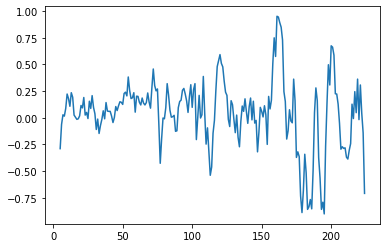

In [70]:
plt.plot(first_diff)

In [92]:
def generate_time_lags(df,col, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n, col}"] = df_n[col].shift(n)
    #df_n = df_n.iloc[n_lags:]
    return df_n

In [93]:
test_2008 = corn_year_dict_new[2008][['Labels', 'Date', 'Close', 'High', 'Low','PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5','Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']]

In [94]:
test_2008

,Labels,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,...,Beginning Stocks,Production,Imports,Total Supply,Feed and Residual,FSI,Ethanol,Total Domestic,Exports,Total Use
0,-1,2007-10-01,3.6875,3.7650,3.6800,0.00,75.0,58.0,21.0,30.0,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
1,-1,2007-10-02,3.4875,3.6875,3.4875,1.37,73.0,51.0,33.1,47.0,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
2,-1,2007-10-03,3.4450,3.5150,3.4225,0.00,74.0,47.0,16.1,19.9,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
3,-1,2007-10-04,3.4225,3.4975,3.4100,0.00,82.0,54.0,17.0,21.9,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
4,-1,2007-10-05,3.4225,3.4375,3.3950,0.00,85.0,67.0,25.9,33.1,...,-0.723040,0.118574,-0.650767,-0.127715,1.528997,-1.899161,-2.000121,-1.047591,1.094595,-0.374951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,2008-09-23,5.6025,5.6175,5.4950,0.04,82.0,64.0,21.0,25.9,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
221,0,2008-09-24,5.6300,5.7400,5.5500,0.13,79.0,61.0,21.0,23.9,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
222,0,2008-09-25,5.5825,5.6550,5.5500,0.00,80.0,57.0,15.0,17.0,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097
223,0,2008-09-29,5.1300,5.4225,5.1000,0.66,71.0,52.0,25.9,32.0,...,-0.300849,-0.086635,-0.560453,-0.181517,2.006520,-2.371407,-2.429656,-1.250932,1.556459,-0.341097


In [98]:
df_generated = test_2008
for column in list(test_2008.keys()):
    print(column)
    df_generated = generate_time_lags(df_generated, column, 20)
df_generated[]


Labels
Date
Close
High
Low
PRCP
TMAX
TMIN
WSF2
WSF5
Area Planted
Area Harvested
Yield
Beginning Stocks
Production
Imports
Total Supply
Feed and Residual
FSI
Ethanol
Total Domestic
Exports
Total Use


,Labels,Date,Close,High,Low,PRCP,TMAX,TMIN,WSF2,WSF5,...,"lag(11, 'Total Use')","lag(12, 'Total Use')","lag(13, 'Total Use')","lag(14, 'Total Use')","lag(15, 'Total Use')","lag(16, 'Total Use')","lag(17, 'Total Use')","lag(18, 'Total Use')","lag(19, 'Total Use')","lag(20, 'Total Use')"
0,-1,2007-10-01,3.6875,3.7650,3.6800,0.00,75.0,58.0,21.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,2007-10-02,3.4875,3.6875,3.4875,1.37,73.0,51.0,33.1,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,2007-10-03,3.4450,3.5150,3.4225,0.00,74.0,47.0,16.1,19.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,2007-10-04,3.4225,3.4975,3.4100,0.00,82.0,54.0,17.0,21.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,2007-10-05,3.4225,3.4375,3.3950,0.00,85.0,67.0,25.9,33.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0,2008-09-23,5.6025,5.6175,5.4950,0.04,82.0,64.0,21.0,25.9,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
221,0,2008-09-24,5.6300,5.7400,5.5500,0.13,79.0,61.0,21.0,23.9,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
222,0,2008-09-25,5.5825,5.6550,5.5500,0.00,80.0,57.0,15.0,17.0,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097
223,0,2008-09-29,5.1300,5.4225,5.1000,0.66,71.0,52.0,25.9,32.0,...,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097,-0.341097


In [89]:
list(test_2008.keys())

['Labels',
 'Date',
 'Close',
 'High',
 'Low',
 'PRCP',
 'TMAX',
 'TMIN',
 'WSF2',
 'WSF5',
 'Area Planted',
 'Area Harvested',
 'Yield',
 'Beginning Stocks',
 'Production',
 'Imports',
 'Total Supply',
 'Feed and Residual',
 'FSI',
 'Ethanol',
 'Total Domestic',
 'Exports',
 'Total Use']